## Characterize novel internal exons that we have in PODER vs. GENCODE

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *
from scripts.sm_utils import *

In [6]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [7]:
gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_file

ref_gtf_file = proc_cfg(config['ref']['gtf'], od)
ref_gtf_file


'../ref/annot.gtf'

In [9]:
# get internal exons from each annotation

In [102]:
def make_exon_id(df):
    """
    Get an ID for each unique exon using 
    Chromosome, Strand, Start, End
    """
    df['eid'] = df['Chromosome'].astype(str)+'_'+\
                df['Strand'].astype(str)+'_'+\
                df['Start'].astype(str)+'_'+\
                df['End'].astype(str)+'_'
    return df
    

In [103]:
# PODER
df = pr.read_gtf(gtf_file).df
df = df.loc[df.Feature=='exon']

# remove first and last exons
df['first_or_last_exon'] = (~df.duplicated('transcript_id', keep='first'))|\
                           (~df.duplicated('transcript_id', keep='last'))
df = df.loc[~df.first_or_last_exon]
df = make_exon_id(df)

# only keep unique exons
df = df[['Chromosome', 'Strand', 'Start', 'End', 'eid']].drop_duplicates(keep='first')

In [104]:
# GENCODE
ref_df = pr.read_gtf(ref_gtf_file).df
ref_df = ref_df.loc[ref_df.Feature=='exon']

# remove first and last exons
ref_df['first_or_last_exon'] = (~ref_df.duplicated('transcript_id', keep='first'))|\
                           (~ref_df.duplicated('transcript_id', keep='last'))
ref_df = ref_df.loc[~ref_df.first_or_last_exon]
ref_df = make_exon_id(ref_df)

# only keep unique exons
ref_df = ref_df[['Chromosome', 'Strand', 'Start', 'End', 'eid']].drop_duplicates(keep='first')

In [105]:
# do a pyranges left join w/ PODER 
df = pr.PyRanges(df)
ref_df = pr.PyRanges(ref_df)
df = df.join(ref_df,
             strandedness='same',
             how='left',
             report_overlap=True,
             slack=0, suffix='_gc')

## How many uniq exons are there in PODER?

In [106]:
df = df.df

In [107]:
n_uniq_poder = len(df.eid.unique())
print(f'{n_uniq_poder} unique internal exons in PODER')

169847 unique internal exons in PODER


## How many exons are completely present in GC?

In [108]:
n_perfect_match = len(list(set(df.eid.tolist())&set(ref_df.eid.tolist())))
print(f'{(n_perfect_match/n_uniq_poder)*100:.2f}% ({n_perfect_match}/{n_uniq_poder}) internal exons have perfect matches in GENCODE v47')

93.89% (159476/169847) internal exons have perfect matches in GENCODE v47


## How many exons are not in GC (not perfect matches)?

In [109]:
no_perfect_match_list = list(set(df.eid.tolist())-set(ref_df.eid.tolist()))
n_no_perfect_match = len(no_perfect_match_list)
print(f'{(n_no_perfect_match/n_uniq_poder)*100:.2f}% ({n_no_perfect_match}/{n_uniq_poder}) internal exons have NO perfect matches in GENCODE v47')

6.11% (10371/169847) internal exons have NO perfect matches in GENCODE v47


## How many no perfect match exons at least overlap a known GC exon (and thus represent alt. 3'/5' splicing)

In [110]:
n_no_perfect_match_overlap = len(df.loc[(df.eid.isin(no_perfect_match_list))&\
                      (df.Overlap<=0)].eid.unique())
print(f'{(n_no_perfect_match_overlap/n_no_perfect_match)*100:.2f}% ({n_no_perfect_match_overlap}/{n_no_perfect_match}) internal exons with NO perfect matches in GENCODE v47 DONT overlap w/ a GENCODE exon')

38.75% (4019/10371) internal exons with NO perfect matches in GENCODE v47 DONT overlap w/ a GENCODE exon


## Plots

In [111]:
temp = df[['eid']].drop_duplicates()
temp['novelty'] = 'Novel'
temp.loc[temp.eid.isin(df.loc[df.Overlap>=1].eid.tolist()), 'novelty'] = "Novel 5'/3'"
temp.loc[temp.eid.isin(df.eid_gc.tolist()), 'novelty'] = 'Known'

In [112]:
temp = temp.groupby('novelty').count().rename({'eid':'n_e'}, axis=1).reset_index()
temp['n_total_e'] = temp.n_e.sum()
temp['perc'] = (temp['n_e']/temp['n_total_e'])*100
temp

,novelty,n_e,n_total_e,perc
0,Known,159476,169847,93.893916
1,Novel,4019,169847,2.366247
2,Novel 5'/3',6352,169847,3.739836


In [113]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [114]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_e==h, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.09)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot:.2f}%', (x, y), size = 18)

In [115]:
temp

,novelty,n_e,n_total_e,perc
0,Known,159476,169847,93.893916
1,Novel,4019,169847,2.366247
2,Novel 5'/3',6352,169847,3.739836


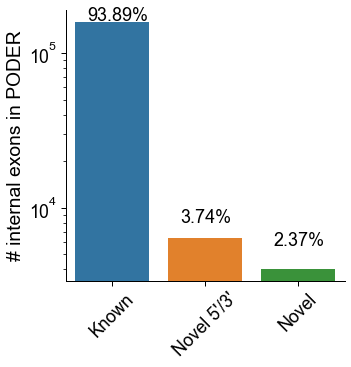

In [116]:
# number of known exons,
# number of novel exons (3'/5' splicing),
# number of novel exons (completely novel)
init_plot_settings(aspect='square')
ax = sns.barplot(temp, y='n_e', 
                 x='novelty', order=['Known', "Novel 5'/3'", 'Novel'])
add_perc_2(ax, temp)
ylabel = '# internal exons in PODER'
ax.set(ylabel=ylabel, xlabel='', yscale='log')
clean_figure(ax)

## But what % of completely novel exons come from known genes?

In [117]:
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [118]:
temp = df[['eid']].drop_duplicates()
temp['novelty'] = 'Novel'
temp.loc[temp.eid.isin(df.loc[df.Overlap>=1].eid.tolist()), 'novelty'] = "Novel 5'/3'"
temp.loc[temp.eid.isin(df.eid_gc.tolist()), 'novelty'] = 'Known'

In [119]:
df = pr.read_gtf(gtf_file).df
df = df.loc[df.Feature=='exon']

# remove first and last exons
df['first_or_last_exon'] = (~df.duplicated('transcript_id', keep='first'))|\
                           (~df.duplicated('transcript_id', keep='last'))
df = df.loc[~df.first_or_last_exon]
df = make_exon_id(df)

In [120]:
temp = temp.loc[temp.novelty=='Novel']

In [121]:
# add tids
temp = temp.merge(df[['transcript_id', 'gene_id', 'eid']], 
                  how='left',
                  on='eid')

In [125]:
# add gene biotype, from master table
temp = temp.merge(mt_df[['associated_geneid.v', 'associated_gene_biotype']],
                  how='left',
                  left_on='gene_id',
                  right_on='associated_geneid.v')

In [131]:
# add gene biotype, from master table
temp = temp.merge(mt_df[['associated_geneid.v', 'structural_category']],
                  how='left',
                  left_on='gene_id',
                  right_on='associated_geneid.v')

In [132]:
# drop dupes
temp = temp[['eid', 'novelty', 'gene_id', 'associated_gene_biotype', 'structural_category']].drop_duplicates()

In [134]:
temp.loc[temp.associated_gene_biotype.isnull(), 'structural_category'].unique()

array(['Fusion', 'Intergenic', 'Antisense', 'Genic'], dtype=object)

In [137]:
# drop dupe
inds = temp.loc[temp.associated_gene_biotype.isnull()].index
temp.loc[inds, 'associated_gene_biotype'] = temp.loc[inds, 'structural_category']
temp = temp[['eid', 'novelty', 'gene_id', 'associated_gene_biotype']].drop_duplicates()

In [145]:
temp2.head()

,associated_gene_biotype,n_e_gene
0,Antisense,371
1,Fusion,453
2,Genic,5
3,Intergenic,236
4,lncRNA,729


In [140]:
temp2 = temp[['eid', 'associated_gene_biotype']].groupby('associated_gene_biotype').count().reset_index().rename({'eid':'n_e_gene'}, axis=1)

In [143]:
def get_biotype_novelty_colors():
    c_dict_1 = {'protein_coding': '#287373',
                'lncRNA': '#f89e5c'}
    c_dict, order = get_novelty_colors(['Antisense', 'Fusion', 'Genic', 'Intergenic'])
    c_dict = c_dict.update(c_dict_1)
    order = ['protein_coding', 'lncRNA']+order
    return c_dict, order

In [144]:
c_dict, order = get_biotype_novelty_colors()

In [157]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_e_gene==h, 'n_e_gene'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.05)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot}', (x, y), size = 18)

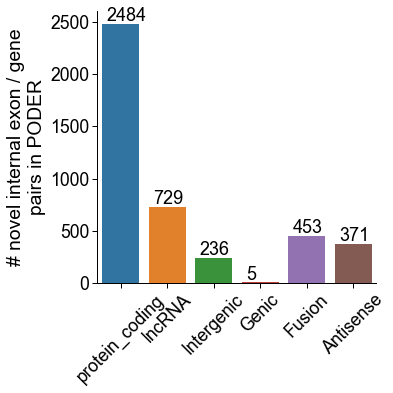

In [165]:
# number of known exons,
# number of novel exons (3'/5' splicing),
# number of novel exons (completely novel)
init_plot_settings(aspect='square')
ax = sns.barplot(temp2, y='n_e_gene', 
                 x='associated_gene_biotype',
                 order=order,
                 palette=c_dict)
add_perc_2(ax, temp2)
ylabel = '# novel internal exon / gene\npairs in PODER'
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)

In [23]:
# df.loc[df.transcript_id=='ENST00000741425.1', ['Feature', 'transcript_id', 'Start', 'End', 'first_or_last_exon']]

In [31]:
# def make_exon_id(df):
#     """
#     Get an ID for each unique exon using 
#     Chromosome, Strand, Start, End
#     """
#     df['eid'] = df['Chromosome'].astype(str)+'_'+\
#                 df['Strand'].astype(str)+'_'+\
#                 df['Start'].astype(str)+'_'+\
#                 df['End'].astype(str)+'_'
#     return df
    

In [32]:
# df = make_exon_id(df)

In [33]:
# df.head()